## Price Elasticity and Optimization in Python (feat. pyGAM)

In [ ]:
# install libraries
!pip install pygam
!pip install pytimetk

In [1]:
# import libraries
import os
import warnings

# data analysis 
import pandas as pd 
import numpy as np

# modeling
import statsmodels.api as sm
from pygam import s, ExpectileGAM, s, l, f
from sklearn.preprocessing import LabelEncoder

# visualization
import plotly.express as px 
from plotnine import * 
import pytimetk as tk 
import textwrap

warnings.filterwarnings("ignore")

In [2]:
directory = r'/Users/akash/Documents/GitHub/priceOptimizationUsingPyGAM'
os.chdir(directory)
print(os.getcwd())

/Users/akash/Documents/GitHub/priceOptimizationUsingPyGAM


In [3]:
# load data
data = pd.read_csv('data/retail_price.csv')

print(data.head())
print(data.describe(include='all').T)

   price  quantity_sold                           product         event
0  24.98            175  Standard Case | iPhone15 Pro Max  Black Friday
1  16.24             98  Standard Case | iPhone15 Pro Max      No Promo
2  12.32            103  Standard Case | iPhone15 Pro Max      No Promo
3  10.82            148  Standard Case | iPhone15 Pro Max    New iPhone
4  43.30             52  Standard Case | iPhone15 Pro Max      No Promo
                count unique                               top  freq  \
price          1600.0    NaN                               NaN   NaN   
quantity_sold  1600.0    NaN                               NaN   NaN   
product          1600      4  Standard Case | iPhone15 Pro Max   400   
event            1600      5                          No Promo  1522   

                    mean        std   min    25%     50%   75%    max  
price          52.264169  26.234423  10.0  29.17  49.985  75.0  99.97  
quantity_sold  50.713125  31.270345   0.0   26.0    50.0  73.0 

### Data preparation

In [5]:
data['is_event'] = (data['event'] != 'No Promo').astype(int).astype(str)
data['revenue'] = data['price'] * data['quantity_sold']
print(data.head())

   price  quantity_sold                           product         event  \
0  24.98            175  Standard Case | iPhone15 Pro Max  Black Friday   
1  16.24             98  Standard Case | iPhone15 Pro Max      No Promo   
2  12.32            103  Standard Case | iPhone15 Pro Max      No Promo   
3  10.82            148  Standard Case | iPhone15 Pro Max    New iPhone   
4  43.30             52  Standard Case | iPhone15 Pro Max      No Promo   

  is_event  revenue  
0        1  4371.50  
1        0  1591.52  
2        0  1268.96  
3        1  1601.36  
4        0  2251.60  


### Exploratory data analysis

In [7]:
# trends: price vs quantity sold
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold',
    color='product',
    opacity=0.6,
    trendline='lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Price vs Quantity Analysis',
    width=800,
    height=600,
).update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10)),
).update_layout(
    legend_title_text='Product',
    title_font=dict(size=16),
    legend_font=dict(size=10),
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10),
).update_yaxes(
    title_text='Quantity Sold',
    title_font=dict(size=10),
    tickfont=dict(size=10),
)
    
fig

### Event analysis (Outliers)

In [9]:
# scatter plot
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold', 
    color='event',
    facet_col='product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.1,
    opacity=0.6,
    trendline='lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Event Analysis',
    width=800, 
    height=700,
).update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10)),
).update_layout(
    legend_title_text='Product', 
    title_font=dict(size=16),
    legend_font=dict(size=10),
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10),
    matches=None,
).update_yaxes(
    title_text='Quantity Sold',
    title_font=dict(size=10),
    tickfont=dict(size=10),
    matches=None,
)
    
    
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10)

fig.for_each_xaxis(lambda axis: axis.update(showticklabels=True))
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))

fig

### Modeling event impact

In [11]:
df_encoded = data.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['event', 'product'], drop_first=False)

colnames_event = df_encoded.columns[df_encoded.columns.str.startswith('event')].tolist()
df_encoded[colnames_event] = df_encoded[colnames_event].astype(int)

colnames_product = df_encoded.columns[df_encoded.columns.str.startswith('product')].tolist()
df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)

print(df_encoded.head())

   price  quantity_sold is_event  revenue  event_Black Friday  \
0  24.98            175        1  4371.50                   1   
1  16.24             98        0  1591.52                   0   
2  12.32            103        0  1268.96                   0   
3  10.82            148        1  1601.36                   0   
4  43.30             52        0  2251.60                   0   

   event_Christmas  event_New iPhone  event_No Promo  event_The Big Game  \
0                0                 0               0                   0   
1                0                 0               1                   0   
2                0                 0               1                   0   
3                0                 1               0                   0   
4                0                 0               1                   0   

   product_Premium Case | iPhone15  product_Premium Case | iPhone15 Pro Max  \
0                                0                                       

In [12]:
X = df_encoded[['price'] + colnames_event + colnames_product]

# add a constant to the model (intercept)
X = sm.add_constant(X) 
y = df_encoded['quantity_sold']

In [13]:
model = sm.OLS(y, X).fit()
print(model.summary())
print(model.params)

                            OLS Regression Results                            
Dep. Variable:          quantity_sold   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1652.
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:45:16   Log-Likelihood:                -5993.4
No. Observations:                1600   AIC:                         1.200e+04
Df Residuals:                    1591   BIC:                         1.205e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [14]:
params_df = pd.DataFrame(model.params).T
print(params_df)

        const     price  event_Black Friday  event_Christmas  \
0  100.911739 -1.016981           54.342819         38.45816   

   event_New iPhone  event_No Promo  event_The Big Game  \
0         12.175097      -24.969318           20.904981   

   product_Premium Case | iPhone15  product_Premium Case | iPhone15 Pro Max  \
0                        25.242249                                25.729874   

   product_Standard Case | iPhone15  product_Standard Case | iPhone15 Pro Max  
0                         24.930272                                 25.009344  


In [15]:
np.log((params_df['event_Black Friday'] + params_df['const']) /
       (params_df['event_No Promo'] + params_df['const']))

0    0.715091
dtype: float64

### General price optimization: GAMs

- PROBLEM: Prices are non-linear
- SOLUTION: Use GAMs (Generalized Additive Models)
- GAMs are Like Linear Regression, but allow for non-linear relationships
- NOT as useful for incorporating events

In [17]:
# ⁠keep the entire data as data_filtered
data_filtered = data.query('event == "No Promo"')

# create a list of unique products
unique_products = data_filtered['product'].unique()

# create an empty dataframe to store the concatenated results
all_gam_results = pd.DataFrame()

# loop through each product 
for product in unique_products:
    # filter data for the current product
    product_data = data_filtered[data_filtered['product'] == product]
                            
    X = product_data[['price']]
    y = product_data['quantity_sold']

    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}
    
    # fit the GAM model for the filtered data
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q)
        gam.fit(X, y)
        gam_results[f'pred_{q}'] = gam.predict(X)
                            
    # store the results in a datatrame with index that matches the original data
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

    # concatenate the results column-wise with the original data 
    predictions_gam_df = pd.concat([product_data[['price', 'product', 'quantity_sold']], predictions_gam], axis=1)

    # concatenate results row-wise
    all_gam_results = pd.concat([all_gam_results, predictions_gam_df], axis=0)

print(all_gam_results)

      price                           product  quantity_sold  pred_0.025  \
1     16.24  Standard Case | iPhone15 Pro Max             98   68.818318   
2     12.32  Standard Case | iPhone15 Pro Max            103   75.427175   
4     43.30  Standard Case | iPhone15 Pro Max             52   41.801392   
5     22.17  Standard Case | iPhone15 Pro Max             73   66.352084   
6     27.28  Standard Case | iPhone15 Pro Max             62   61.201025   
...     ...                               ...            ...         ...   
1595  98.83           Premium Case | iPhone15             10    0.248536   
1596  90.09           Premium Case | iPhone15              7    1.271880   
1597  97.38           Premium Case | iPhone15              4    0.401758   
1598  66.31           Premium Case | iPhone15             49   22.155196   
1599  72.23           Premium Case | iPhone15             12   13.052656   

       pred_0.5  pred_0.975  
1     85.093860   99.004638  
2     89.492293  101.431483

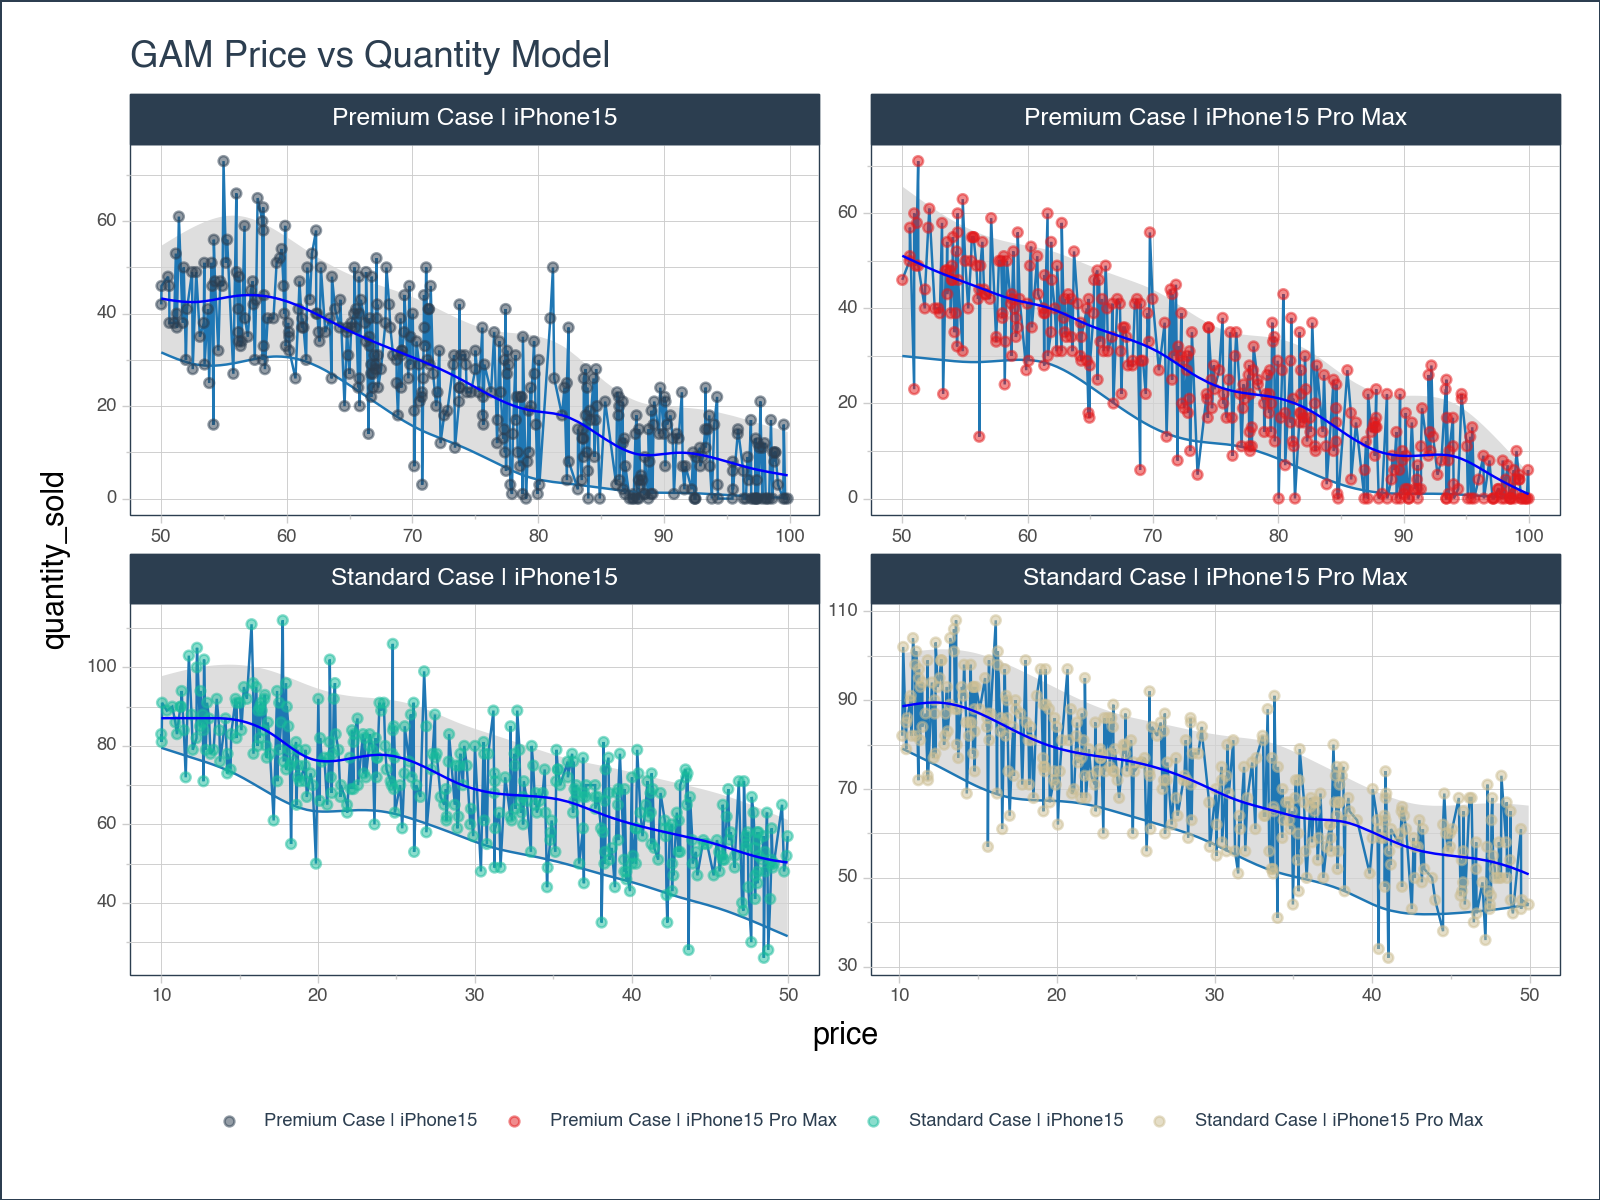

<Figure Size: (800 x 600)>

In [18]:
# visualize the GAM price model results
(ggplot(
    data=all_gam_results, 
    mapping=aes(x='price', y='quantity_sold', color='product', group='product')
) 
+ geom_ribbon(
    aes(ymax='pred_0.975', ymin='pred_0.025'), 
    fill='#d3d3d3', 
    color=None, 
    alpha=0.75, 
    show_legend=False
) 
+ geom_point(alpha=0.5) 
+ geom_line(aes(y='pred_0.5'), color='blue') 
+ facet_wrap('~product', scales='free') 
+ labs(title='GAM Price vs Quantity Model') 
+ scale_color_manual(values=list(tk.palette_timetk().values())) 
+ tk.theme_timetk(width=800, height=600)
)

In [19]:
# calculate predicted revenue for each prediction column
for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_' + col] = all_gam_results['price'] * all_gam_results[col]

# calculate actual revenue
all_gam_results['revenue_actual'] = all_gam_results['price'] * all_gam_results['quantity_sold']

print(all_gam_results)

# find the best price for each product based on different prediction intervals
best_50 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1)) \
    .reset_index(level=0, drop=True)

best_975 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1)) \
    .reset_index(level=0, drop=True)

best_25 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1)) \
    .reset_index(level=0, drop=True)

      price                           product  quantity_sold  pred_0.025  \
1     16.24  Standard Case | iPhone15 Pro Max             98   68.818318   
2     12.32  Standard Case | iPhone15 Pro Max            103   75.427175   
4     43.30  Standard Case | iPhone15 Pro Max             52   41.801392   
5     22.17  Standard Case | iPhone15 Pro Max             73   66.352084   
6     27.28  Standard Case | iPhone15 Pro Max             62   61.201025   
...     ...                               ...            ...         ...   
1595  98.83           Premium Case | iPhone15             10    0.248536   
1596  90.09           Premium Case | iPhone15              7    1.271880   
1597  97.38           Premium Case | iPhone15              4    0.401758   
1598  66.31           Premium Case | iPhone15             49   22.155196   
1599  72.23           Premium Case | iPhone15             12   13.052656   

       pred_0.5  pred_0.975  revenue_pred_0.025  revenue_pred_0.5  \
1     85.093860   

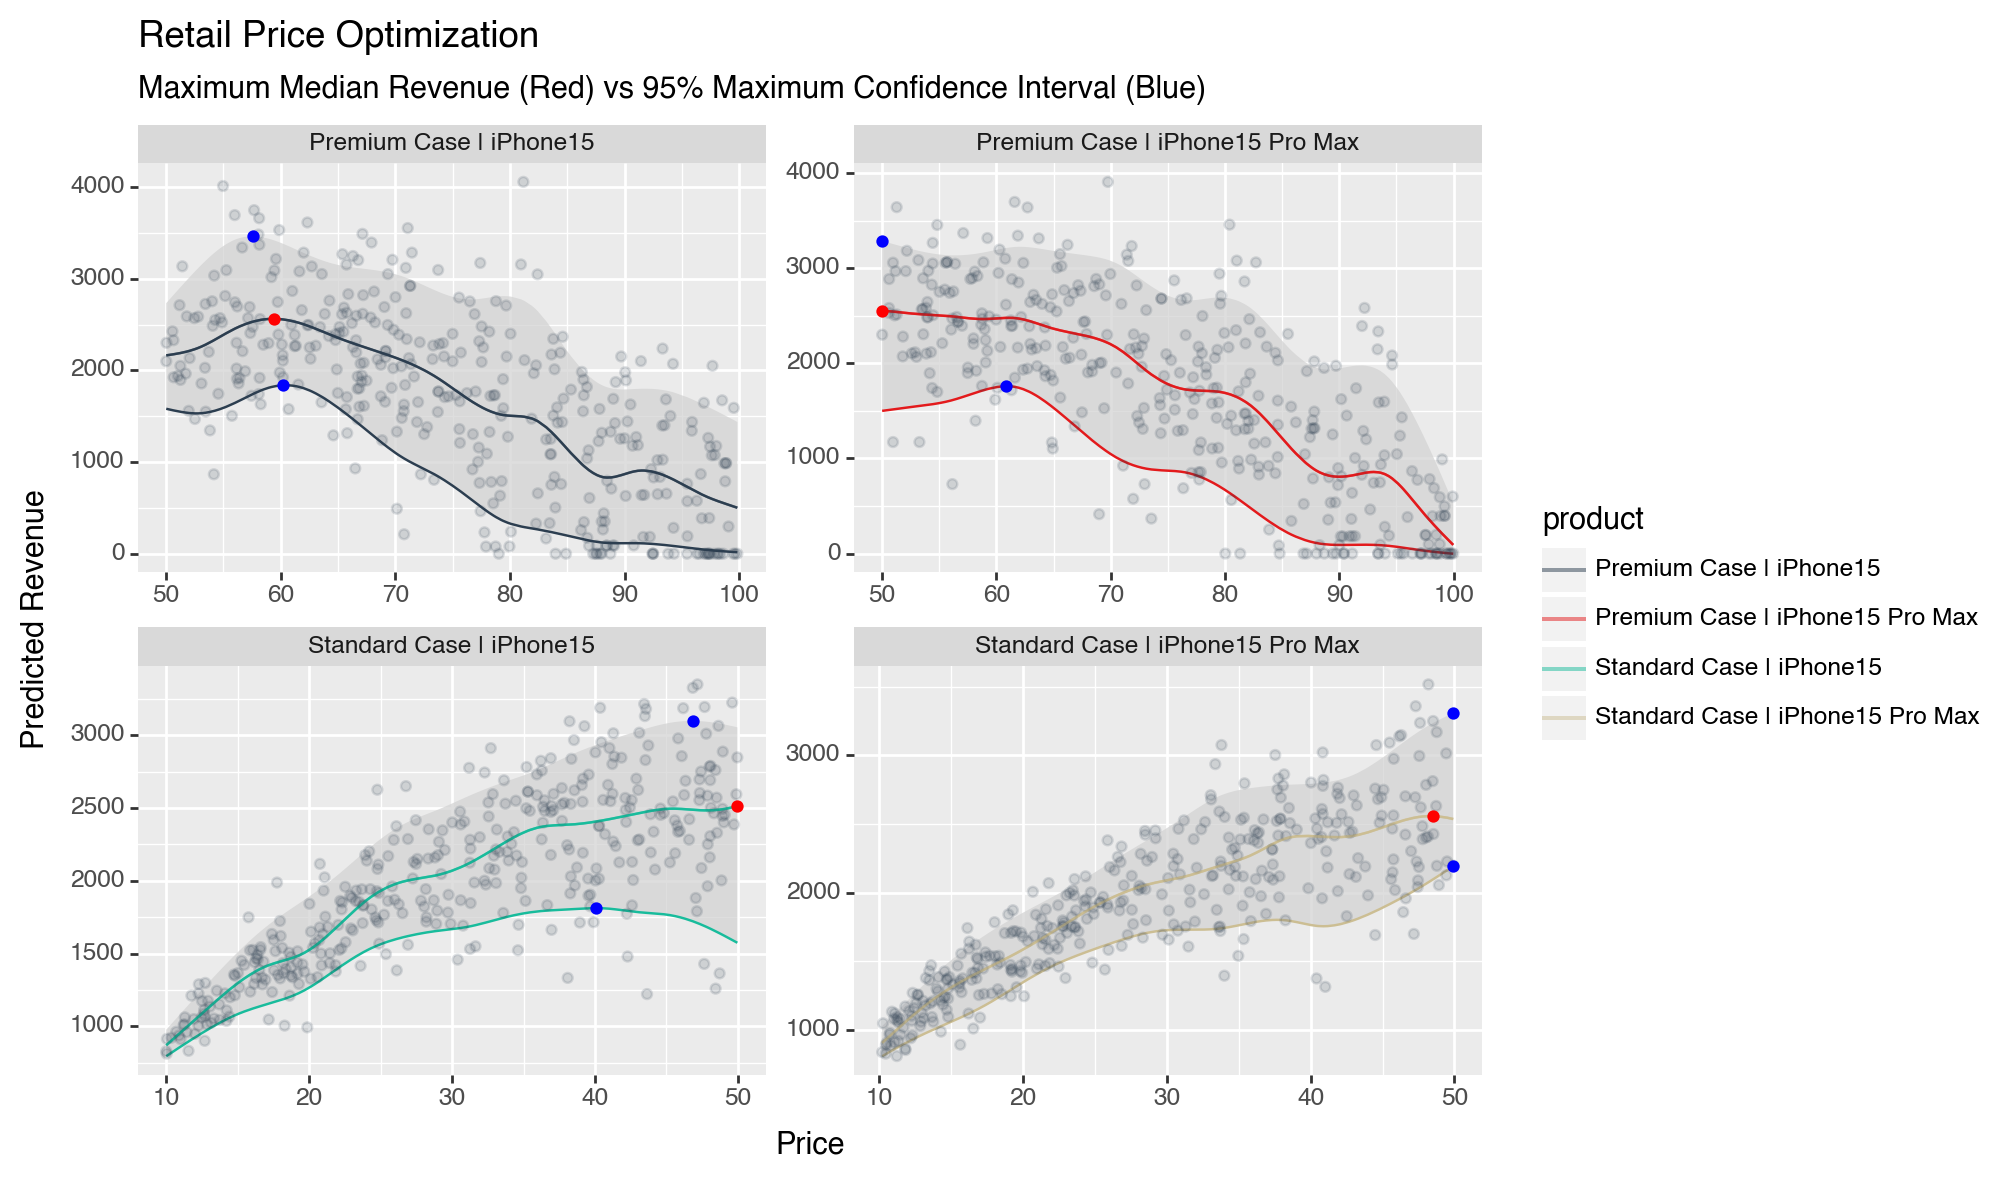

<Figure Size: (1000 x 600)>

In [20]:
(ggplot(
    data=all_gam_results, 
    mapping=aes(x='price', y='revenue_pred_0.5', color='product', group='product')
) 
+ geom_ribbon(
    aes(ymax='revenue_pred_0.975', ymin='revenue_pred_0.025'), 
    fill='#d3d3d3', 
    alpha=0.75, 
    show_legend=False
) 
+ geom_point(aes(y='revenue_actual'), alpha=0.15, color='#2C3E50') 
+ geom_line(aes(y='revenue_pred_0.5'), alpha=0.5) 
+ geom_point(data=best_50, color='red') 
+ geom_point(data=best_975, mapping=aes(y='revenue_pred_0.975'), color='blue') 
+ geom_point(data=best_25, mapping=aes(y='revenue_pred_0.025'), color='blue') 
+ facet_wrap('~product', scales='free') 
+ labs(
    title='Retail Price Optimization',
    subtitle='Maximum Median Revenue (Red) vs 95% Maximum Confidence Interval (Blue)',
    x='Price',
    y='Predicted Revenue'
) 
+ scale_color_manual(values=list(tk.palette_timetk().values())) 
+ theme(figure_size=(10, 6))
)

In [21]:
print(best_50[['product', 'price', 'revenue_pred_0.5', 'revenue_pred_0.025', 'revenue_pred_0.975']])

                               product  price  revenue_pred_0.5  \
1427           Premium Case | iPhone15  59.46       2563.938555   
794    Premium Case | iPhone15 Pro Max  50.01       2554.450651   
1040          Standard Case | iPhone15  49.96       2512.981657   
140   Standard Case | iPhone15 Pro Max  48.49       2557.287130   

      revenue_pred_0.025  revenue_pred_0.975  
1427         1826.751680         3418.954948  
794          1499.684576         3284.050626  
1040         1574.467453         3054.266899  
140          2094.587891         3234.418603  


### Business Insights:
- The GAMs show that the optimal price is at the ends of the price range for: Standard Case | iPhone 15 and Premium Case | iPhone 15 Pro Max. 
- This suggest that the company should consider a price increase for these models


- The GAMs show that the optimal price is in the middle of the price range for Standard Case | iPhone 15 Pro Max and Premium Case | iPhone 15.
- This suggest that the company should consider a price that is close to the red dots for these products

### Modeling GAMs with events
- Essentially the same process as above, but we need to filter out the "No Promo" events
- Gets a little tricky because of limited data points for each event

In [28]:
# keep the entire data as data_filtered 
data_filtered = data.query('event != "No Promo"')

# ⁠create a list of unique products and events 
unique_products = data_filtered['product'].unique()

events_only_gam_results = pd.DataFrame()

In [43]:
# loop through each product 
for product in unique_products:
    # filter data for the current product
    product_data = data_filtered[data_filtered['product'] == product]

    if len(product_data) == 0:
        continue # skip to next iteration if no data for current product

    X = product_data[['price', 'event']]
    y = product_data['quantity_sold']

    # encode the event column
    le = LabelEncoder()
    X['event'] = le.fit_transform(X['event'])

    # use f(1) to indicate that the event column is categorical
    gam = ExpectileGAM(l(0) + f(1))

    gam.fit(X, y)
    
    # create a DataFrame with predictions
    gam_results = pd.DataFrame({'pred_0.5': gam.predict(X)}, index=X.index)

    # concatenate the results column-wise with the original data 
    predictions_gam_df = pd.concat([product_data[['price', 'product', 'event', 'quantity_sold']], gam_results], axis=1)

    # concatenate results row-wise 
    events_only_gam_results = pd.concat([events_only_gam_results, predictions_gam_df], axis=0)

print(events_only_gam_results)

      price                           product         event  quantity_sold  \
0     24.98  Standard Case | iPhone15 Pro Max  Black Friday            175   
3     10.82  Standard Case | iPhone15 Pro Max    New iPhone            148   
19    12.98  Standard Case | iPhone15 Pro Max     Christmas            156   
40    24.55  Standard Case | iPhone15 Pro Max    New iPhone             91   
71    47.62  Standard Case | iPhone15 Pro Max  Black Friday            138   
...     ...                               ...           ...            ...   
1471  53.89           Premium Case | iPhone15  Black Friday            145   
1482  97.78           Premium Case | iPhone15  Black Friday             45   
1543  80.86           Premium Case | iPhone15    New iPhone             36   
1565  88.33           Premium Case | iPhone15    New iPhone             40   
1584  57.40           Premium Case | iPhone15     Christmas             98   

        pred_0.5  
0     155.233162  
3     140.823301  
19    

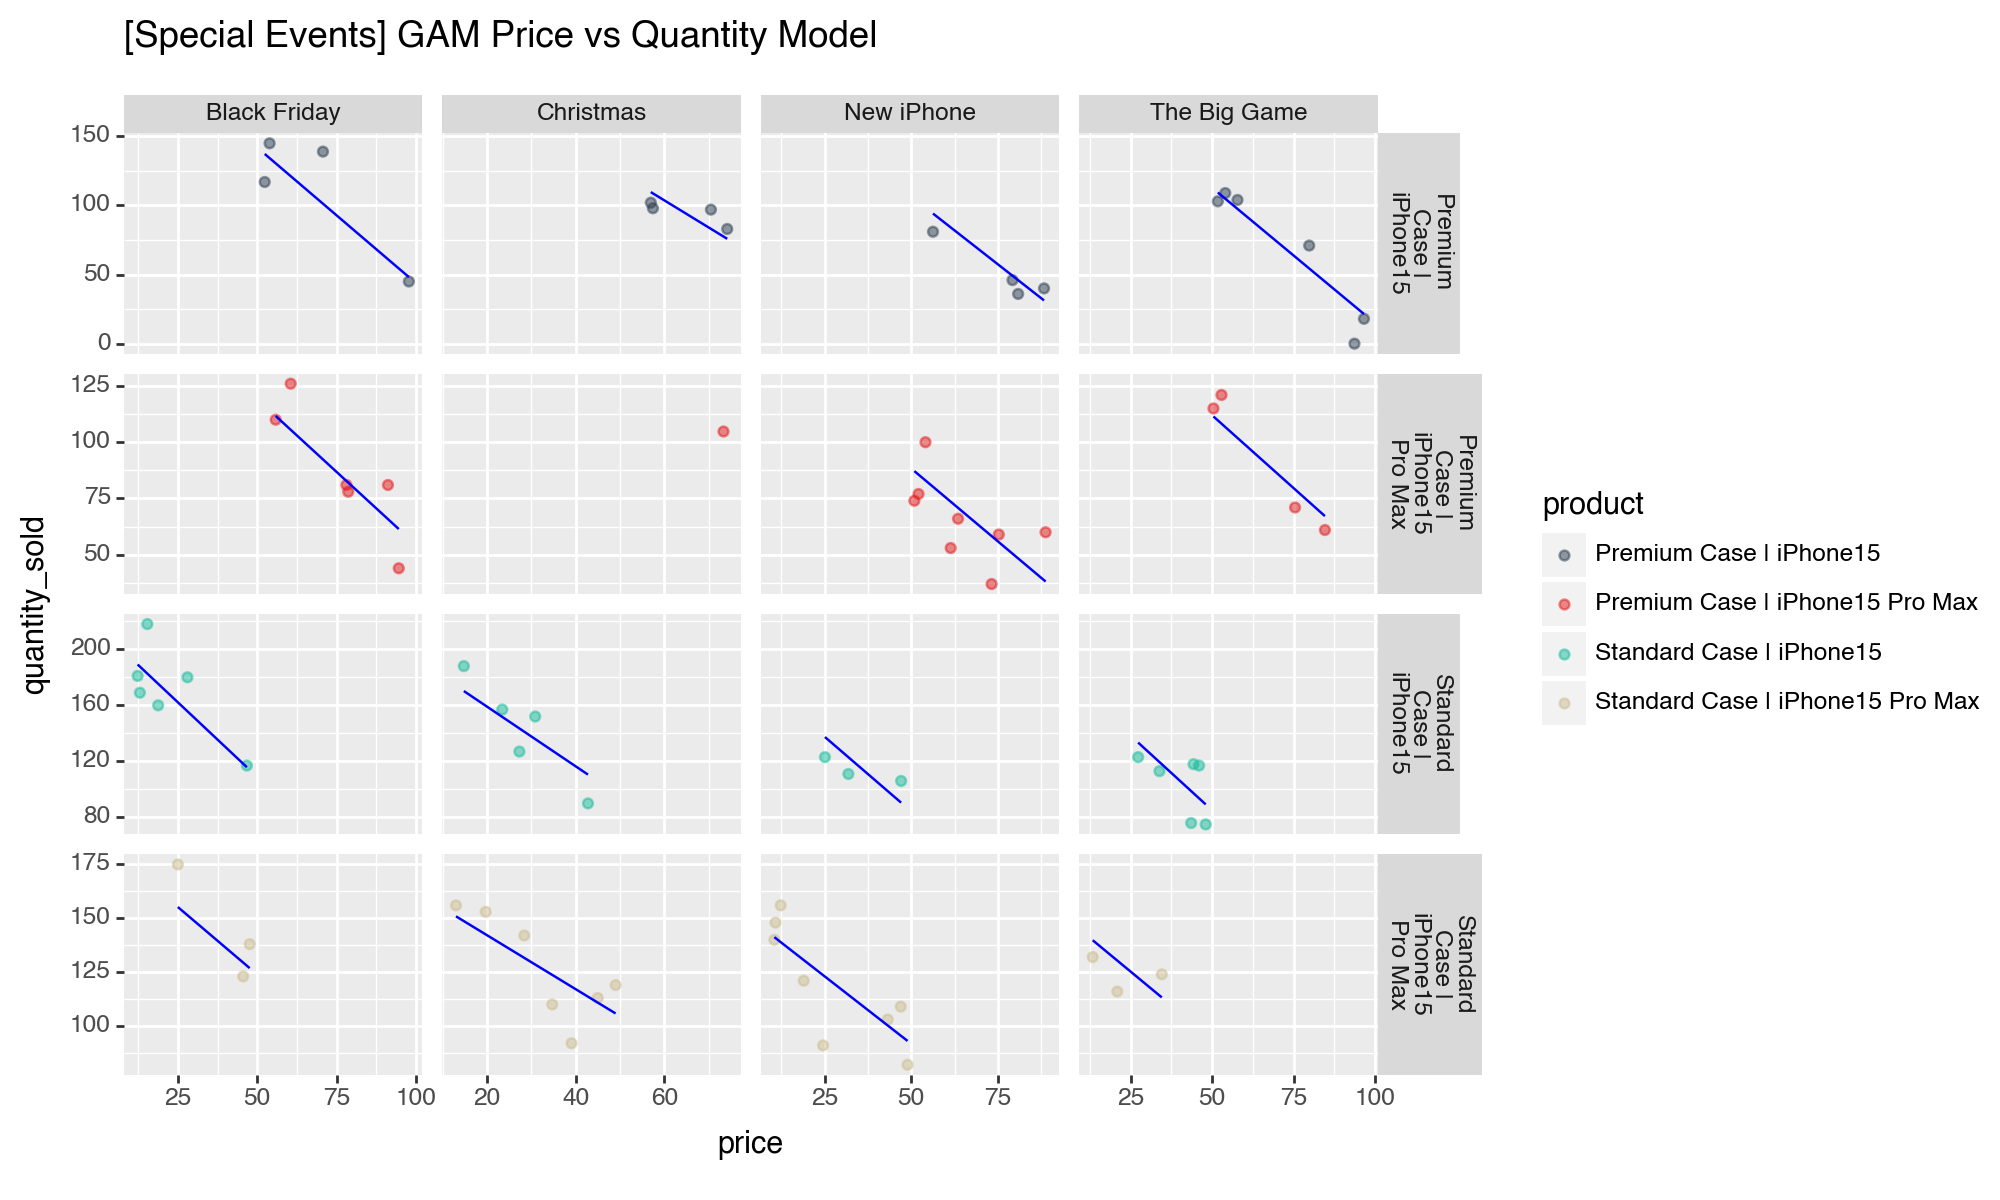

<Figure Size: (1000 x 600)>

In [45]:
# define the wrap function
def wrap_label(label, width=10):
    return '\n'.join(textwrap.wrap(label, width=width))

# visualize the GAM price model results 
(ggplot(
    data=events_only_gam_results,
    mapping=aes(x='price', y='quantity_sold', color='product')
)
+ geom_point(alpha=0.5)
+ geom_line(aes(y='pred_0.5'), color='blue')
+ facet_grid('product ~ event', scales='free', labeller=labeller(product=wrap_label))
+ labs(title='[Special Events] GAM Price vs Quantity Model')
+ scale_color_manual(values=list(tk.palette_timetk().values()))
+ theme(figure_size=(10, 6))
)

In [46]:
# optimize price for predicted daily revenue 
for col in events_only_gam_results.columns:
    if col.startswith('pred'):
        events_only_gam_results['revenue_' + col] = events_only_gam_results['price'] * events_only_gam_results[col]

events_only_gam_results['revenue_actual'] = events_only_gam_results['price'] * events_only_gam_results['quantity_sold']

print(events_only_gam_results)

best_50 = events_only_gam_results \
    .groupby(['product', 'event']) \
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1)) \
    .reset_index(level=0, drop=True)

      price                           product         event  quantity_sold  \
0     24.98  Standard Case | iPhone15 Pro Max  Black Friday            175   
3     10.82  Standard Case | iPhone15 Pro Max    New iPhone            148   
19    12.98  Standard Case | iPhone15 Pro Max     Christmas            156   
40    24.55  Standard Case | iPhone15 Pro Max    New iPhone             91   
71    47.62  Standard Case | iPhone15 Pro Max  Black Friday            138   
...     ...                               ...           ...            ...   
1471  53.89           Premium Case | iPhone15  Black Friday            145   
1482  97.78           Premium Case | iPhone15  Black Friday             45   
1543  80.86           Premium Case | iPhone15    New iPhone             36   
1565  88.33           Premium Case | iPhone15    New iPhone             40   
1584  57.40           Premium Case | iPhone15     Christmas             98   

        pred_0.5  revenue_pred_0.5  revenue_actual  
0     155.

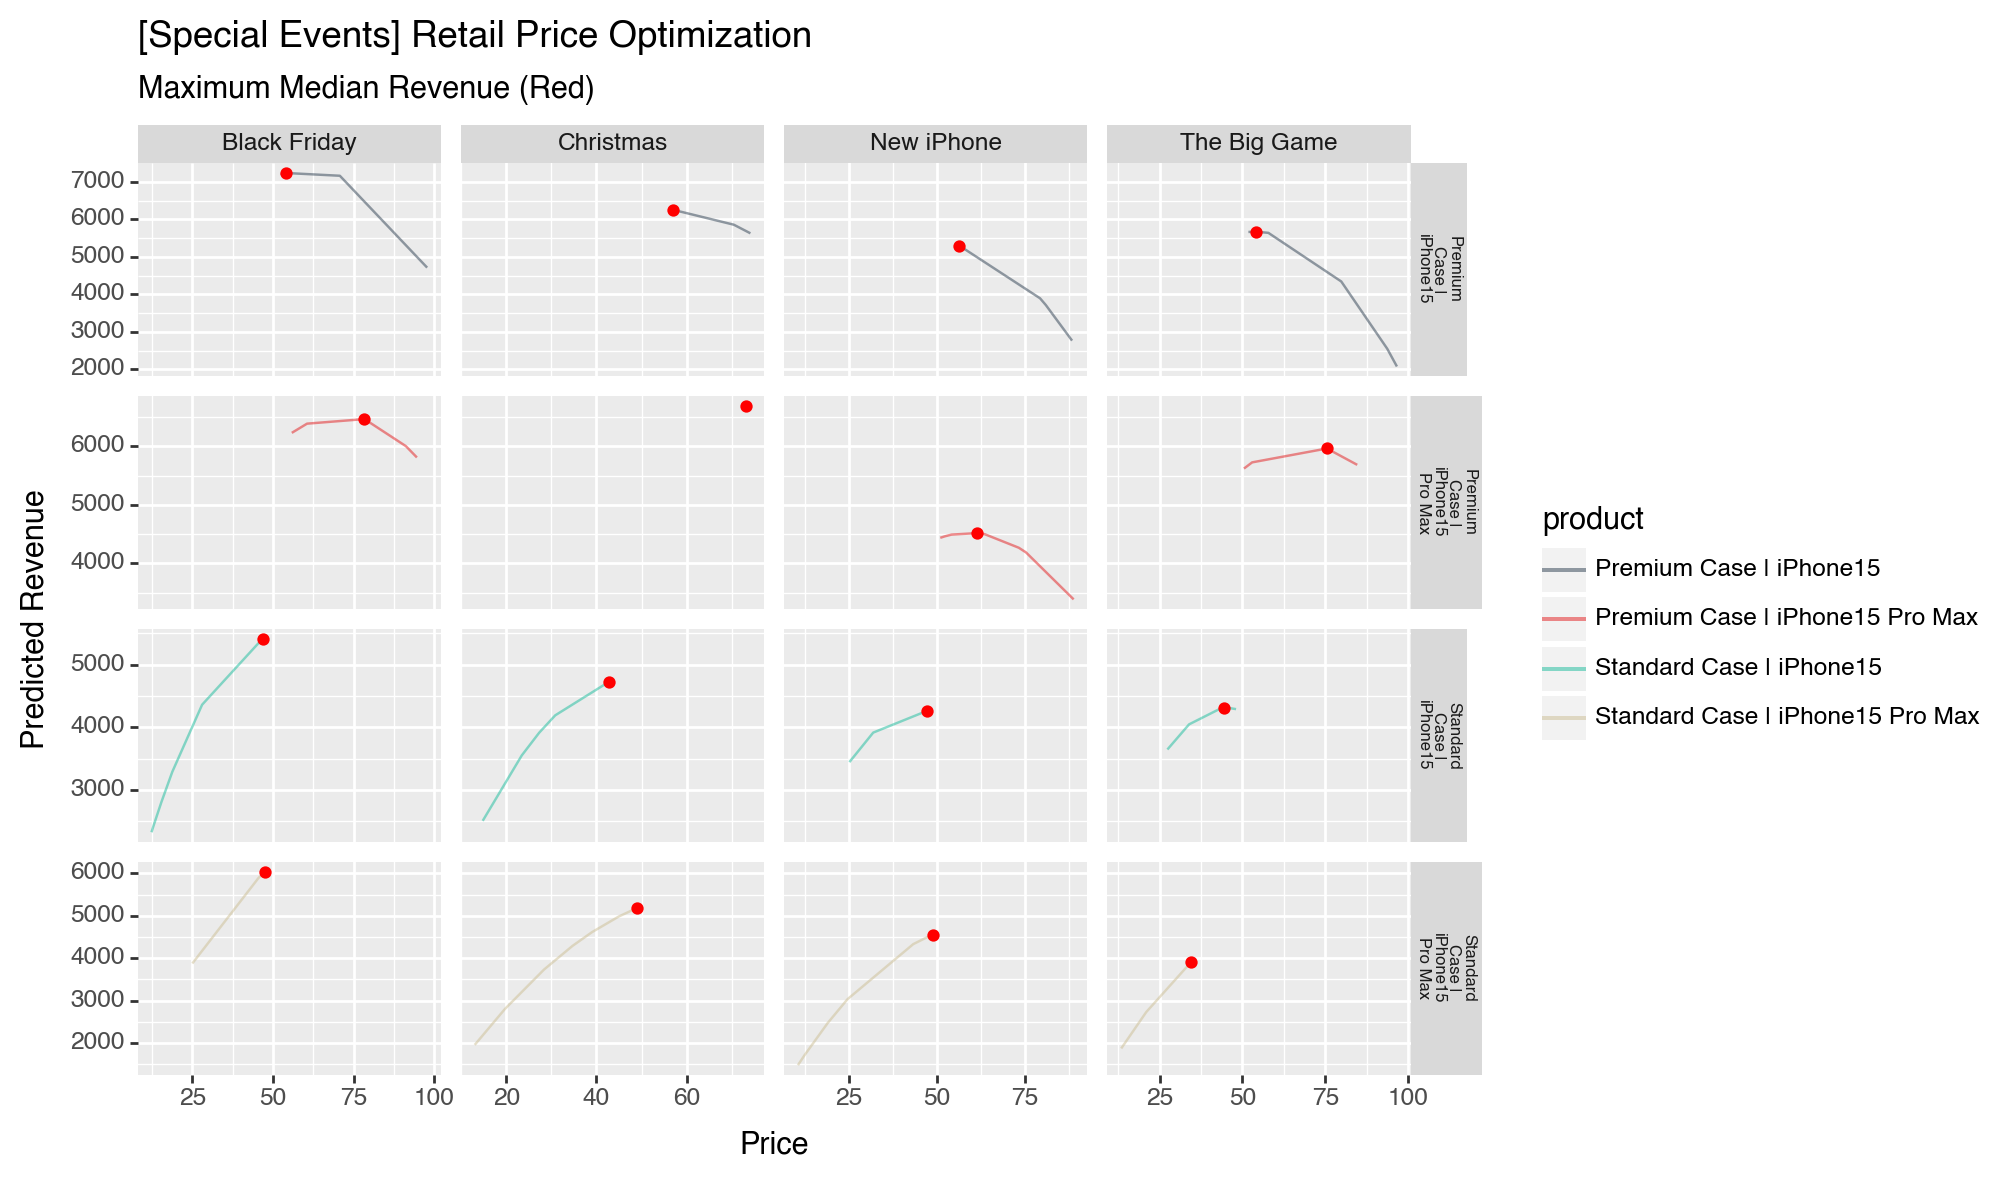

<Figure Size: (1000 x 600)>

In [49]:
# define the wrap function
def wrap_label(label, width=10):
    return '\n'.join(textwrap.wrap(label, width=width))

# visualize the GAM price model results
(ggplot(
    data=events_only_gam_results, 
    mapping=aes(x='price', y='revenue_pred_0.5', color='product', group='product')
) 
+ geom_line(alpha=0.5) 
+ geom_point(data=best_50, color='red') 
+ facet_grid('product ~ event', scales='free', labeller=labeller(product=wrap_label)) 
+ labs(
    title='[Special Events] Retail Price Optimization',
    subtitle='Maximum Median Revenue (Red)',
    x='Price',
    y='Predicted Revenue'
) 
+ scale_color_manual(values=list(tk.palette_timetk().values())) 
+ theme(
    figure_size=(10, 6),
    strip_text_y=element_text(size=6)
)
)

### Business Insights:
- Events have a significant impact on price optimization.
- Prices should be optimized for each special event (e.g. Black Friday, Christmas)
- For demand decreasing events (e.g. New iPhone Model comes out), prices should be lowered to maximize revenue based on historical data.